## Regularized parallel and cascaded approaches using SiameseFWI
Authors: Ulises Berman & Omar Saad Aly

In this notebook, Vp time-lapse changes are estimated with the parallel and cascaded approaches using SiameseFWI.

### Setting Up the Libs and Marmousi2 Configurations

In [1]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 8.                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = [20, 20]                 # step interval along x/z direction
dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 94                   # model shape of z dimension (depth) Seam Arid
ny        = 400                   # model shape of y dimension Seam Arid
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 30                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 400        # number of receivers per shot
source_spacing = np.floor( ny / (num_shots))                         # space intervel between neigbouring sources
receiver_spacing = np.floor( ny / (num_receivers_per_shot))         # space intervel between neigbouring receivers        # space intervel between neigbouring receivers
source_depth = 2                # the index depth of sources, default is 0
receiver_depth = 0              # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [10,10,0,10]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

fwi_lr            = 20        # learning rate for updating the model.
fwi_batch         = 30      # number of batches for FWI.
fwi_num_epochs    = 51       # number of FWI iteration.
sim_lr            = 1*1e-4    # learning rate for Soamese network.
survey_pad = None
savepoch = 10                 # Saving models each 50 FWI iterations

/home/bermanu/Ulises/miniconda3/envs/ElasticSiameseFWI/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##   Check Cuda Device 


In [2]:
# Set device
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
print(device)

cuda


In [3]:
# Print which device is used
print('Using device:', device)
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA TITAN RTX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

set_seed(0)   

True

In [5]:
# Set sources and array configuration
# x_s
x_s = torch.zeros(num_shots, num_sources_per_shot, 2,
                               dtype=torch.long, device=device)
x_s[..., 1] = source_depth
x_s[:, 0, 0] = (torch.arange(1, num_shots+1) * source_spacing)

# x_r
x_r = torch.zeros(num_shots, num_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
x_r[..., 1] = receiver_depth
x_r[:, :, 0] = (
    (torch.arange(num_receivers_per_shot) * receiver_spacing).repeat(num_shots, 1)
)

receiver_spacing, source_spacing

(1.0, 13.0)

## Create monitor model

In [6]:
from deepwave import scalar
from scipy.ndimage import gaussian_filter

data_path = 'data/over_94_400.bin'

fwi_result = 'results/Overthrust_noise2/'
# Loading the true model
base_true_vp = loadtruemodel(data_path, num_dims, vmodel_dim).cpu().numpy()

# Perturb velocity models
monitor_true_vp  = perturb_velocity_model(base_true_vp, center = (55, 110),lateral_extent = 30,vertical_layer_width = 4,
    max_vertical_extent_dilation = 60,compaction_magnitude = 250,dilation_magnitude = 120)
monitor_true_vp  = perturb_velocity_model(monitor_true_vp, center = (78, 310),lateral_extent = 40,vertical_layer_width = 5,
    max_vertical_extent_dilation = 70,compaction_magnitude = -250,dilation_magnitude = -120)

# Convert models to tensors and put them to device
base_true_vp = torch.from_numpy(base_true_vp).float().to(device)
monitor_true_vp = torch.from_numpy(monitor_true_vp).float().to(device)

# # Shift the value range
base_true_vp = denormalize_vp(normalize_vp(base_true_vp, vmin=base_true_vp.min(), vmax=base_true_vp.max()))
monitor_true_vp = denormalize_vp(normalize_vp(monitor_true_vp, vmin=monitor_true_vp.min(), vmax=monitor_true_vp.max()))

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/Siamese_FWI/utils/utils.py:881: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


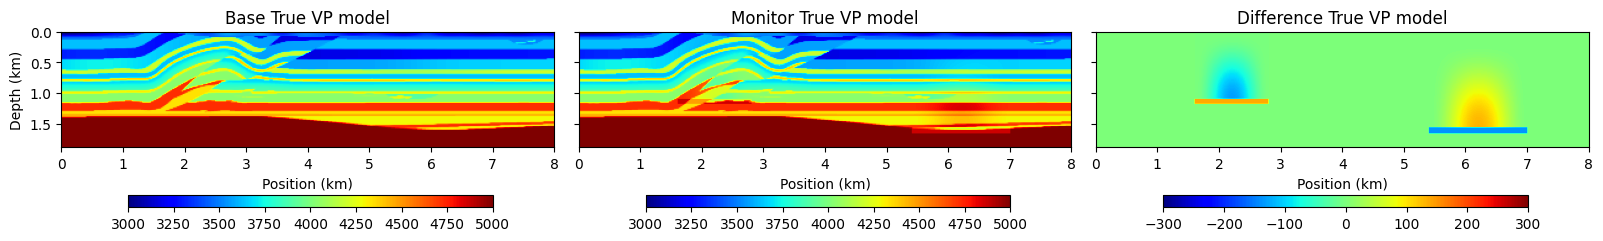

In [7]:
plot_base_monitor(base_true_vp.detach().cpu().numpy(), monitor_true_vp.detach().cpu().numpy(), np.array(dx)/1000, parameter='True VP', diff=300)

/tmp/ipykernel_1850/3984872860.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


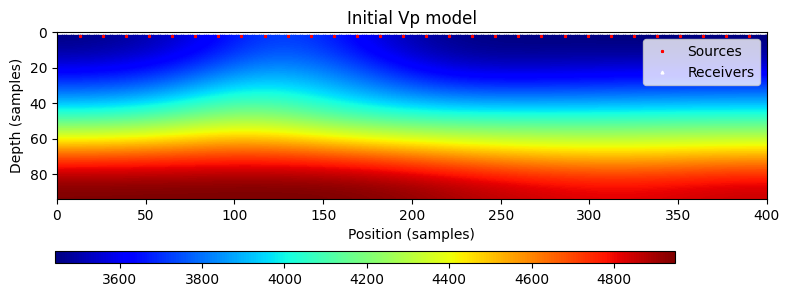

In [8]:
# Smoothed initial model
model_vp = torch.from_numpy(gaussian_filter(base_true_vp.detach().cpu().numpy(), sigma=[15,30])).to(device)
# Loading the true model
model_init_vp = model_vp
model_init_vp = model_init_vp.detach().cpu()
# The model will be updated during FWI
model_vp = torch.nn.Parameter(model_vp)

box_min = monitor_true_vp.cpu().numpy().min()
box_max = monitor_true_vp.cpu().numpy().max()

# Do a 1x3 plot showing true base, monitor and difference models
fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
# Plot true model
vmin=model_init_vp.detach().cpu().numpy().min()
vmax=model_init_vp.detach().cpu().numpy().max()
im = axs.imshow(model_init_vp.detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='jet', \
              extent=[0, model_init_vp.shape[1], model_init_vp.shape[0], 0])
axs.set_title('Initial Vp model')
axs.set_xlabel('Position (samples)')
axs.set_ylabel('Depth (samples)')

pos = axs.get_position()
cbar_ax = fig.add_axes([pos.x0 - 0.05, pos.y0 - 0.12, pos.width, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Plot sources (red stars)
src_x = x_s[:, 0, 0].cpu().numpy()
src_z = x_s[:, 0, 1].cpu().numpy()
axs.plot(src_x, src_z, 'r*', markersize=2, label='Sources')

# Plot receivers (white triangles)
rec_x = x_r[0, :, 0].cpu().numpy()
rec_z = x_r[0, :, 1].cpu().numpy()
axs.plot(rec_x, rec_z, 'w^', markersize=2, label='Receivers')

axs.legend(loc='upper right')
plt.tight_layout();

In [9]:
# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(peak_freq, nt, dt, peak_source_time)
    .repeat(num_shots, num_sources_per_shot, 1)
    .to(device)
)

source = source_amplitudes
# source_amplitudes_init = source
# receiver Amplitude
receiver_amplitudes_true = scalar(base_true_vp.T, dx, dt, source_amplitudes=source.to(device),
                 source_locations=x_s.to(device),
                 receiver_locations=x_r.to(device),
                 accuracy=order,
                 pml_width=pml_width,
                 pml_freq = peak_freq)[-1]

receiver_amplitudes_true = highpass_filter(2.5, receiver_amplitudes_true.cpu(), dt=dt, pad=[10, 10, 0, 0, 0, 0]).to(device)
rcv_amps_true = receiver_amplitudes_true.clone()
rcv_amps_true.shape

torch.Size([30, 400, 2000])

## Plotting the observed data


In [15]:
rcv_amps_true = add_awgn(receiver_amplitudes_true, snr_db=5)

# Compute snr
snr = 10 * torch.log10(
    torch.mean(receiver_amplitudes_true ** 2) /
    torch.mean((receiver_amplitudes_true - rcv_amps_true) ** 2)
).item()
print(f'SNR: {snr:.2f} dB')

SNR: 5.00 dB


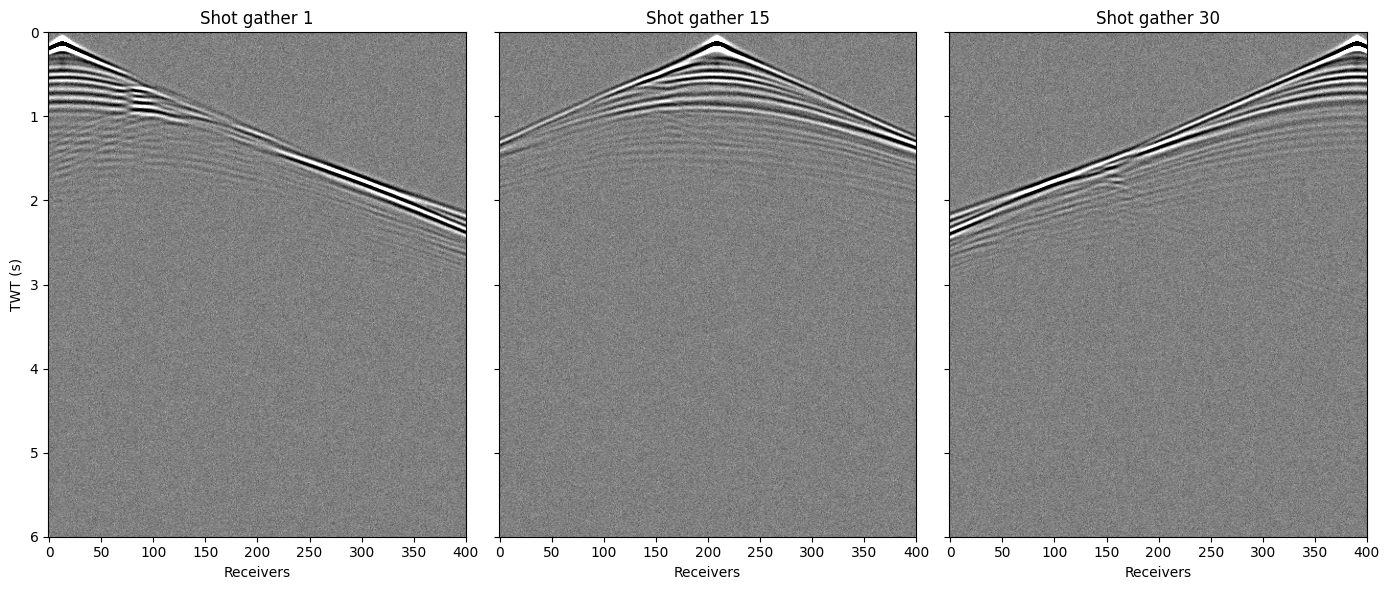

In [16]:
# Plot three shot gathers (beginning, middle and end of num_shots)
fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
vmax = 0.05*receiver_amplitudes_true.max()
vmin = -vmax
# Plot first shot gather
im = axs[0].imshow(rcv_amps_true[0, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[0].set_title('Shot gather 1')
axs[0].set_xlabel('Receivers')
axs[0].set_ylabel('TWT (s)')
# Plot middle shot gather
im = axs[1].imshow(rcv_amps_true[num_shots // 2, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[1].set_title(f'Shot gather {num_shots // 2}')
axs[1].set_xlabel('Receivers')
# Plot last shot gather
im = axs[2].imshow(rcv_amps_true[-1, :, :].cpu().numpy().T, cmap='gray', aspect='auto',
                   extent=[-1, num_receivers_per_shot, nt*dt, 0], vmin=vmin, vmax=vmax)
axs[2].set_title(f'Shot gather {num_shots}')
axs[2].set_xlabel('Receivers')
plt.tight_layout();

## Setting Up the Siamese and Optimizers

In [17]:
from torchsummary import summary
from Model.Module22 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 10
def lr_lambda1(epoch):
    return 1/2

### optimizer for the velocity model
optimizer = optim.Adam([{'params': model_vp, 'lr':fwi_lr, 'betas':(0.5, 0.9), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.9), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim_s, lr_lambda=lr_lambda)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda1)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

#summary(netD,[(1,nt,num_receivers_per_shot),(1,nt,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0


Number of netD params: 565


## Parallel Approach

In [14]:
## Patches
def patchify(inp, kernel_size, stride, inv=False, orig_size=None):
    if not inv:
        out = inp.unfold(0, kernel_size[0], stride[0]).unfold(1, kernel_size[1], stride[1])
        out = out.reshape(-1, kernel_size[0], kernel_size[1])
        input_ones = torch.ones_like(inp).unfold(0, kernel_size[0], stride[0]).unfold(1, kernel_size[1], stride[1])
        divisor = input_ones.reshape(-1, kernel_size[0], kernel_size[1])

        return out

In [15]:
#### 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR

## Patch size and stride
w1 = 16
w2 = 16
s1z = w1
s2z = w2

t_start = time.time()
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
netD.train() 

for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()               
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        #prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
        #                                  order,survey_pad)
        batch_src_amps = source[it::fwi_batch].to(device)
        batch_rcv_amps_true = rcv_amps_true[it::fwi_batch,:,:].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = scalar(model_vp.T, dx, dt, source_amplitudes=batch_src_amps.to(device),
                         source_locations=batch_x_s.to(device),
                         receiver_locations=batch_x_r.to(device),
                         accuracy=order,
                         pml_width=pml_width)[-1]


        # Prepare the data for Siamese network.
        d_real = batch_rcv_amps_true.permute(0,1,2)
        dataInputF = patchify(d_real[0,:,:],(w1,w2),(s1z,s2z)).reshape(-1, w1,w2)  
        d_real1 = dataInputF.unsqueeze(1)
        
        # train with fake data
        d_fake = batch_rcv_amps_pred.permute(0,1,2)
        dataInputF = patchify(d_fake[0,:,:],(w1,w2),(s1z,s2z)).reshape(-1, w1,w2)  
        d_fake1 = dataInputF.unsqueeze(1)
        _,_,o1,o2 = netD(d_real1,d_fake1)
        # Measure the Eculedian Loss.
        loss = F.pairwise_distance(o1, o2, keepdim=True).mean()

        epoch_loss += loss.item()
        loss.backward()
        
        # Updating the Siamese network.
        optim_s.step()

        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp.data=torch.clamp(model_vp.data,min=1e-12,max=5000)


    # Update the learning rate each 100 FWI iterations .
    if (i>0) and (i%100==0):
        scheduler.step()
        scheduler1.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizer.param_groups[0]["lr"]
    # if i%10==0:
    #     plot()
        
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model_vp.detach().cpu().numpy(), \
              base_true_vp.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model_vp.detach().cpu().numpy(), \
              base_true_vp.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model_vp.detach().cpu().numpy(), \
              base_true_vp.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'BaseVP_.mat', \
                         {'rec':model_vp.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'BaseMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


KeyboardInterrupt: 

## Plotting the Reconstructed Velocity Model

Final results Vp:
Loss = 0.6869350949923198
SNR = 31.432927907953427)
SSIM = 0.7040567398071289)
RE = 0.026813506045146658)


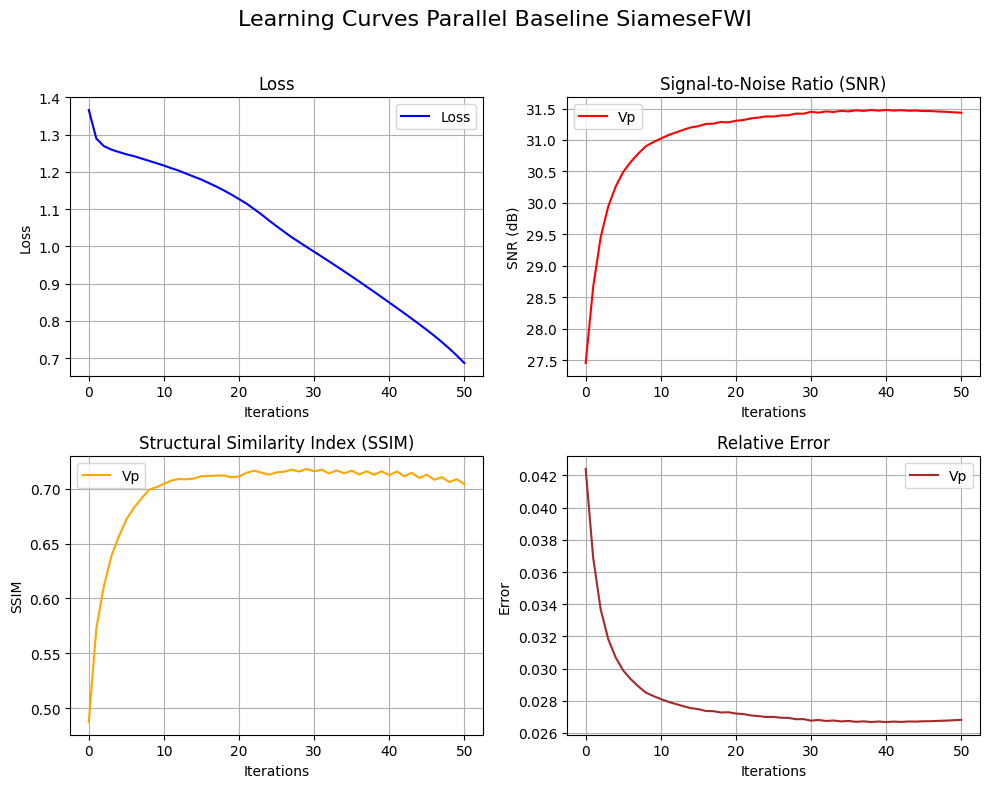

In [7]:
plot_metrics_fwi(fwi_result, 'BaseMetric_.mat', title='Parallel Baseline SiameseFWI')

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/Siamese_FWI/utils/utils.py:919: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


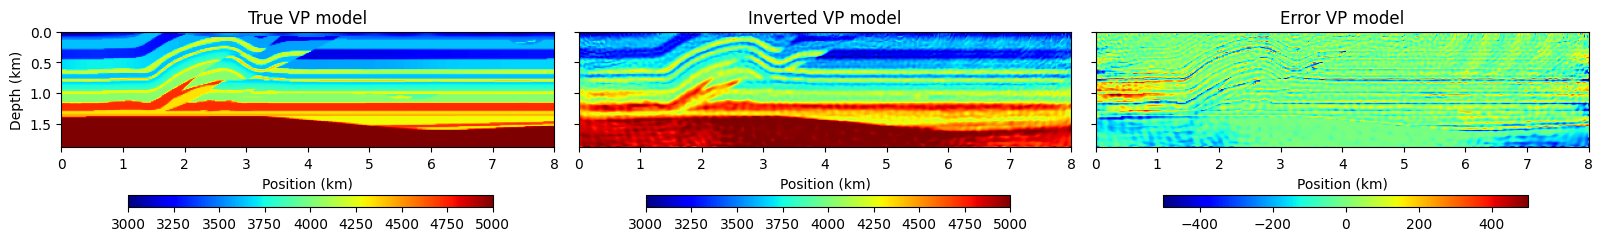

In [16]:
base_inv_vp = scipy.io.loadmat(fwi_result + 'BaseVP_.mat')
base_inv_vp = base_inv_vp['rec']

base_true_vp = base_true_vp.detach().cpu()
plot_true_inv(base_true_vp.numpy(), base_inv_vp, np.array(dx)/1000, parameter='VP', diff=500)

## Monitor parallel inversion

In [17]:
# Model monitor data
receiver_amplitudes_true = scalar(monitor_true_vp.T, dx, dt, source_amplitudes=source.to(device),
                 source_locations=x_s.to(device),
                 receiver_locations=x_r.to(device),
                 accuracy=order,
                 pml_width=pml_width,
                 pml_freq = peak_freq)[-1]

receiver_amplitudes_true = highpass_filter(2.5, receiver_amplitudes_true.cpu(), dt=dt, pad=[10, 10, 0, 0, 0, 0]).to(device)
rcv_amps_true = receiver_amplitudes_true.clone()
rcv_amps_true.shape

torch.Size([30, 400, 2000])

In [18]:
# Add noise
rcv_amps_true = add_awgn(rcv_amps_true, snr_db=5)
# Compute snr
snr = 10 * torch.log10(
    torch.mean(receiver_amplitudes_true ** 2) /
    torch.mean((receiver_amplitudes_true - rcv_amps_true) ** 2)
).item()
print(f'SNR: {snr:.2f} dB')

SNR: 5.00 dB


In [19]:
# Reinitialize starting models
model_vp = model_init_vp.clone().to(device)
model_vp = torch.nn.Parameter(model_vp)

In [20]:
from torchsummary import summary
from Model.Module22 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 10
def lr_lambda1(epoch):
    return 1/2

### optimizer for the velocity model
optimizer = optim.Adam([{'params': model_vp, 'lr':fwi_lr, 'betas':(0.5, 0.9), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.9), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim_s, lr_lambda=lr_lambda)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda1)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

#summary(netD,[(1,nt,num_receivers_per_shot),(1,nt,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0


Number of netD params: 565


In [22]:
base_inv_vp = torch.from_numpy(base_inv_vp).float().to(device)

In [23]:
#### 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR

## Patch size and stride
w1 = 16
w2 = 16
s1z = w1
s2z = w2

t_start = time.time()
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
netD.train() 

for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()               
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        #prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
        #                                  order,survey_pad)
        batch_src_amps = source[it::fwi_batch].to(device)
        batch_rcv_amps_true = rcv_amps_true[it::fwi_batch,:,:].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = scalar(model_vp.T, dx, dt, source_amplitudes=batch_src_amps.to(device),
                         source_locations=batch_x_s.to(device),
                         receiver_locations=batch_x_r.to(device),
                         accuracy=order,
                         pml_width=pml_width)[-1]


        # Prepare the data for Siamese network.
        d_real = batch_rcv_amps_true.permute(0,1,2)
        dataInputF = patchify(d_real[0,:,:],(w1,w2),(s1z,s2z)).reshape(-1, w1,w2)  
        d_real1 = dataInputF.unsqueeze(1)
        
        # train with fake data
        d_fake = batch_rcv_amps_pred.permute(0,1,2)
        dataInputF = patchify(d_fake[0,:,:],(w1,w2),(s1z,s2z)).reshape(-1, w1,w2)  
        d_fake1 = dataInputF.unsqueeze(1)
        _,_,o1,o2 = netD(d_real1,d_fake1)
        # Measure the Eculedian Loss.
        loss = F.pairwise_distance(o1, o2, keepdim=True).mean()

        reg_loss = 0.6e-9*(TVLoss(model_vp - base_inv_vp))

        loss = loss + reg_loss

        epoch_loss += loss.item()
        loss.backward()
        
        # Updating the Siamese network.
        optim_s.step()

        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp.data=torch.clamp(model_vp.data,min=1e-12,max=5000)


    # Update the learning rate each 100 FWI iterations .
    if (i>0) and (i%100==0):
        scheduler.step()
        scheduler1.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizer.param_groups[0]["lr"]
    # if i%10==0:
    #     plot()
        
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'MonitorVP_.mat', \
                         {'rec':model_vp.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'MonitorMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 

Epoch: 1 Loss:  1.3733969966570536 lr_DL: 0.0001 lr_vel: 20 SNR: 27.304378802138302 SSIM: 0.4805114
Epoch: 2 Loss:  1.2949358065923056 lr_DL: 0.0001 lr_vel: 20 SNR: 28.549419209070976 SSIM: 0.56905156
Epoch: 3 Loss:  1.2734715461730957 lr_DL: 0.0001 lr_vel: 20 SNR: 29.459658275179127 SSIM: 0.61594963
Epoch: 4 Loss:  1.2629975239435831 lr_DL: 0.0001 lr_vel: 20 SNR: 30.05672492808045 SSIM: 0.6492347
Epoch: 5 Loss:  1.255494769414266 lr_DL: 0.0001 lr_vel: 20 SNR: 30.450713805117992 SSIM: 0.66982466
Epoch: 6 Loss:  1.2498722116152445 lr_DL: 0.0001 lr_vel: 20 SNR: 30.70528110312837 SSIM: 0.6841447
Epoch: 7 Loss:  1.2430222868919372 lr_DL: 0.0001 lr_vel: 20 SNR: 30.86211187805649 SSIM: 0.69385874
Epoch: 8 Loss:  1.2365409811337789 lr_DL: 0.0001 lr_vel: 20 SNR: 30.986175216495674 SSIM: 0.69999653
Epoch: 9 Loss:  1.2294597188631693 lr_DL: 0.0001 lr_vel: 20 SNR: 31.07680968670911 SSIM: 0.70679
Epoch: 10 Loss:  1.222523848215739 lr_DL: 0.0001 lr_vel: 20 SNR: 31.122634475258593 SSIM: 0.7055577
Ep

KeyboardInterrupt: 

Final results Vp:
Loss = 0.8971267282962799
SNR = 31.447208434064002)
SSIM = 0.7090727686882019)
RE = 0.02676945800995448)


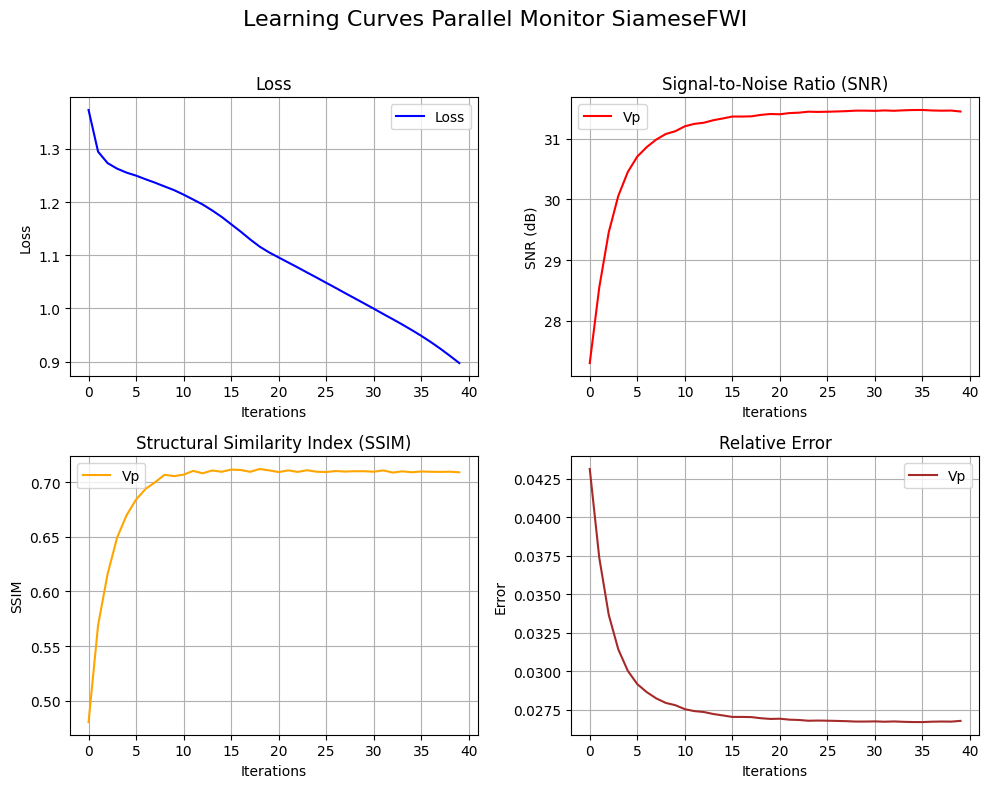

In [8]:
plot_metrics_fwi(fwi_result, 'MonitorMetric_.mat', title='Parallel Monitor SiameseFWI')

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/Siamese_FWI/utils/utils.py:919: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


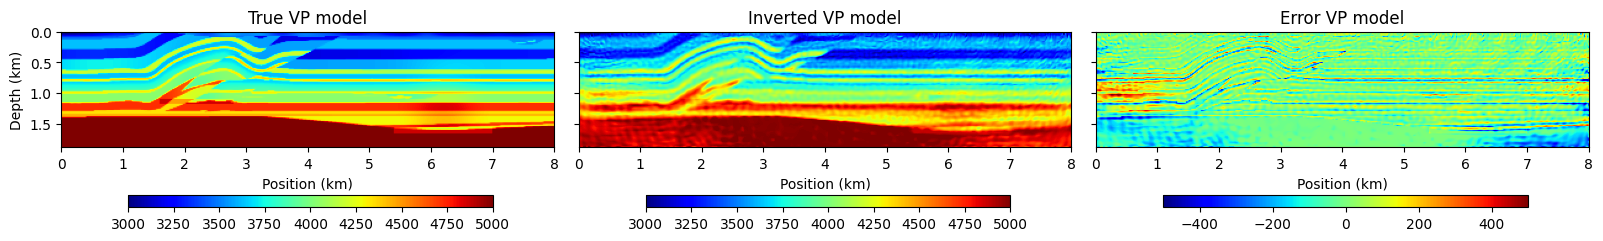

In [24]:
monitor_inv_vp = scipy.io.loadmat(fwi_result + 'MonitorVP_.mat')
monitor_inv_vp = monitor_inv_vp['rec']

monitor_true_vp = monitor_true_vp.detach().cpu()
plot_true_inv(monitor_true_vp.numpy(), monitor_inv_vp, np.array(dx)/1000, parameter='VP', diff=500)

/home/bermanu/Ulises/Advanced_Seismic_Inversion/Project/Siamese_FWI/utils/utils.py:881: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


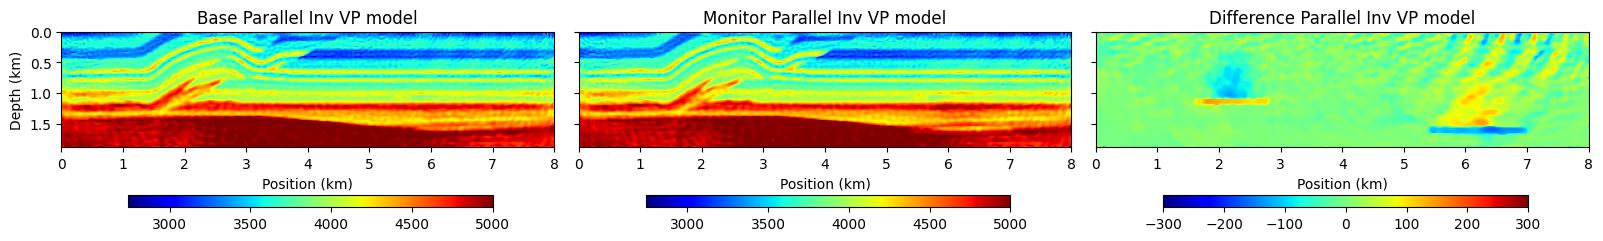

In [26]:
plot_base_monitor(base_inv_vp.cpu().numpy(), monitor_inv_vp, np.array(dx)/1000, parameter='Parallel Inv VP', diff=300)

## Monitor cascaded inversion

In [21]:
# Reinitialize starting models
model_vp = torch.from_numpy(base_inv_vp).clone().to(device)
model_vp = torch.nn.Parameter(model_vp)

In [22]:
from torchsummary import summary
from Model.Module22 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 10
def lr_lambda1(epoch):
    return 1/2

### optimizer for the velocity model
optimizer = optim.Adam([{'params': model_vp, 'lr':fwi_lr, 'betas':(0.5, 0.9), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.9), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim_s, lr_lambda=lr_lambda)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda1)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

#summary(netD,[(1,nt,num_receivers_per_shot),(1,nt,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0


Number of netD params: 565


In [ ]:
#### 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR

## Patch size and stride
w1 = 16
w2 = 16
s1z = w1
s2z = w2

t_start = time.time()
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
netD.train() 

for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()               
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        #prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
        #                                  order,survey_pad)
        batch_src_amps = source[it::fwi_batch].to(device)
        batch_rcv_amps_true = rcv_amps_true[it::fwi_batch,:,:].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        #batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred = scalar(model_vp.T, dx, dt, source_amplitudes=batch_src_amps.to(device),
                         source_locations=batch_x_s.to(device),
                         receiver_locations=batch_x_r.to(device),
                         accuracy=order,
                         pml_width=pml_width)[-1]


        # Prepare the data for Siamese network.
        d_real = batch_rcv_amps_true.permute(0,1,2)
        dataInputF = patchify(d_real[0,:,:],(w1,w2),(s1z,s2z)).reshape(-1, w1,w2)  
        d_real1 = dataInputF.unsqueeze(1)
        
        # train with fake data
        d_fake = batch_rcv_amps_pred.permute(0,1,2)
        dataInputF = patchify(d_fake[0,:,:],(w1,w2),(s1z,s2z)).reshape(-1, w1,w2)  
        d_fake1 = dataInputF.unsqueeze(1)
        _,_,o1,o2 = netD(d_real1,d_fake1)
        # Measure the Eculedian Loss.
        loss = F.pairwise_distance(o1, o2, keepdim=True).mean()

        epoch_loss += loss.item()
        loss.backward()
        
        # Updating the Siamese network.
        optim_s.step()

        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model_vp,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model_vp.data=torch.clamp(model_vp.data,min=1e-12,max=5000)


    # Update the learning rate each 100 FWI iterations .
    if (i>0) and (i%100==0):
        scheduler.step()
        scheduler1.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizer.param_groups[0]["lr"]
    # if i%10==0:
    #     plot()
        
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model_vp.detach().cpu().numpy(), \
              monitor_true_vp.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'MonitorCasVP_.mat', \
                         {'rec':model_vp.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'MonitorCasMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 
# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 

Epoch: 1 Loss:  1.2708301146825154 lr_DL: 0.0001 lr_vel: 20 SNR: 43.89233064792738 SSIM: 0.9512172
Epoch: 2 Loss:  1.2665862123171487 lr_DL: 0.0001 lr_vel: 20 SNR: 43.61233472846742 SSIM: 0.9398529
Epoch: 3 Loss:  1.2615225275357564 lr_DL: 0.0001 lr_vel: 20 SNR: 43.85065504127044 SSIM: 0.9394305
Epoch: 4 Loss:  1.2576403856277465 lr_DL: 0.0001 lr_vel: 20 SNR: 43.44479959390168 SSIM: 0.92855865
Epoch: 5 Loss:  1.2520046432813008 lr_DL: 0.0001 lr_vel: 20 SNR: 43.679924184113815 SSIM: 0.9323209
Epoch: 6 Loss:  1.2476929346720378 lr_DL: 0.0001 lr_vel: 20 SNR: 43.25949798363751 SSIM: 0.9282476
Epoch: 7 Loss:  1.2421153982480366 lr_DL: 0.0001 lr_vel: 20 SNR: 43.500936657295945 SSIM: 0.9258839
Epoch: 8 Loss:  1.2366763512293497 lr_DL: 0.0001 lr_vel: 20 SNR: 43.02008983642039 SSIM: 0.92141247
Epoch: 9 Loss:  1.2312310576438903 lr_DL: 0.0001 lr_vel: 20 SNR: 42.96328387704783 SSIM: 0.91747826
Epoch: 10 Loss:  1.225411025683085 lr_DL: 0.0001 lr_vel: 20 SNR: 42.859247600657895 SSIM: 0.9182389
Epoc

Final results Vp:
Loss = 0.7164700965086619
SNR = 31.187413852943244)
SSIM = 0.6864081025123596)
RE = 0.02758222566550642)


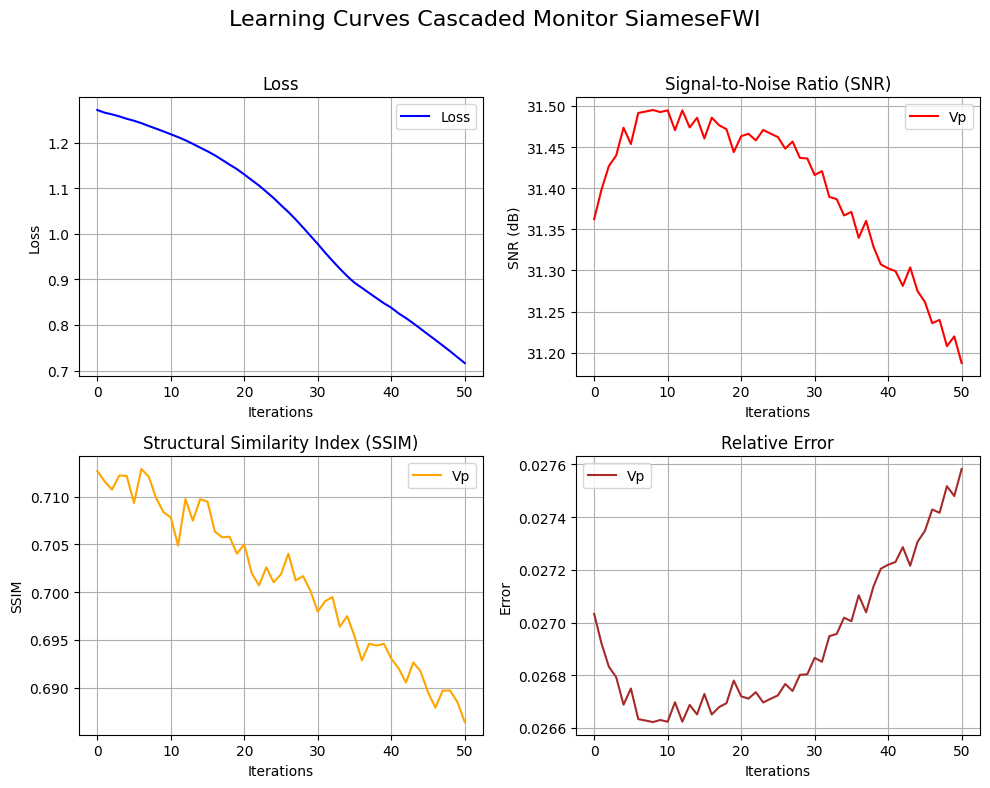

In [9]:
plot_metrics_fwi(fwi_result, 'MonitorCasMetric_.mat', title='Cascaded Monitor SiameseFWI')

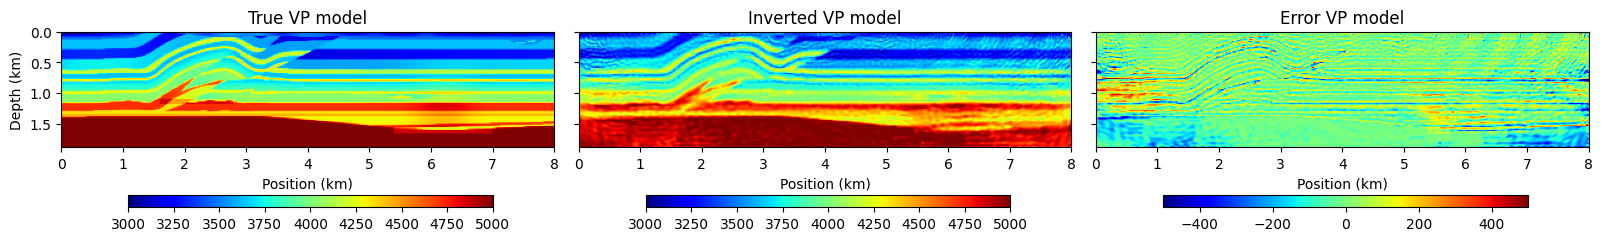

In [23]:
monitor_inv_vp = scipy.io.loadmat(fwi_result + 'MonitorCasVP_.mat')
monitor_inv_vp = monitor_inv_vp['rec']

monitor_true_vp = monitor_true_vp.detach().cpu()
plot_true_inv(monitor_true_vp.numpy(), monitor_inv_vp, np.array(dx)/1000, parameter='VP', diff=500)

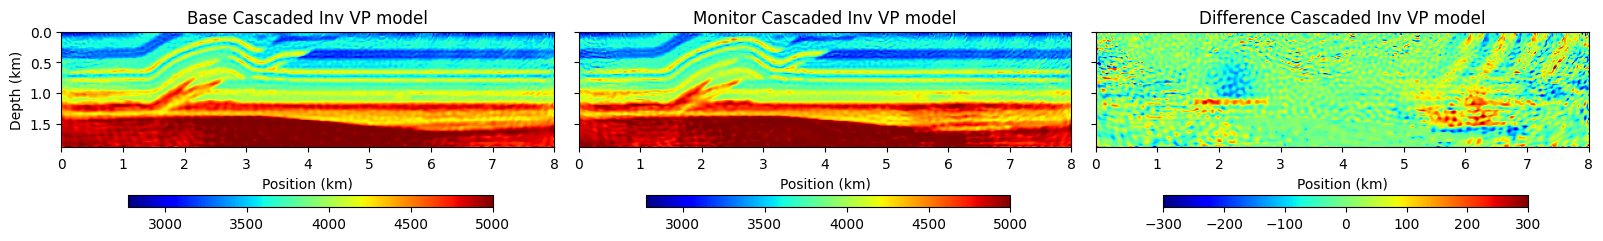

In [24]:
plot_base_monitor(base_inv_vp, monitor_inv_vp, np.array(dx)/1000, parameter='Cascaded Inv VP', diff=300)